# Week 2: Predicting time series

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create one step forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
import unittests

## Generating the data

First things first, you will need to generate your time series data. 

The next cell includes a bunch of helper functions to generate and plot the time series. These are very similar to those you saw on Week 1.

In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Now, define a function to generate the time series, using the functions from the previous cell. This function should return a time series that has trend, seasonality and noise. 

In [12]:
def generate_time_series():
    """ Creates timestamps and values of the time series """
    
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

## Defining some useful global variables

Next, you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length of the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.**


In [13]:
# Save all global variables
SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

Finally, put everything together and create the times series you will use for this assignment. 

In [14]:
# Create the time series
TIME, SERIES = generate_time_series()

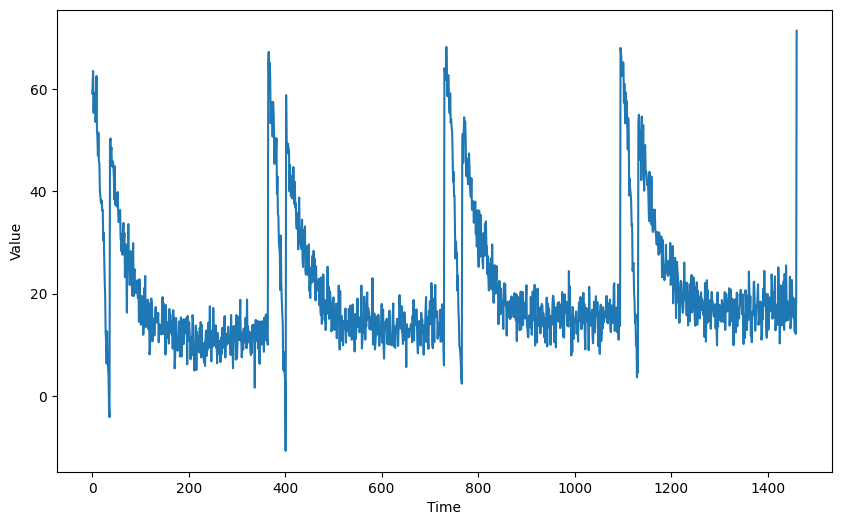

In [15]:
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

## Splitting the data

As usual, you will need a function to split the data between train and validation sets. Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [16]:
def train_val_split(time, series):

    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

## Processing the data

### Exercise 1: windowed_dataset

As you saw on the lectures, you can feed the data for training by creating a TF Dataset with the appropriate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. Remember you can do all these using the different methods of the `tf.data.Dataset` object. Next, complete the `windowed_dataset` function below that effectively pre-processes your time series and returns a TF Dataset.

This function receives a `series` and a `window_size`, and returns a TF Dataset. You should already be familiar with `tf.data.Dataset` objects from the this week's lectures, but be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) if you need any help.

In [17]:
# GRADED FUNCTION: windowed_dataset
def windowed_dataset(series, window_size, shuffle=True):
    """Create a windowed dataset

    Args:
        series (np.ndarray): time series
        window_size (int): length of window to use for prediction
        shuffle (bool): (For testing purposes) Indicates whether to shuffle data before batching or not. Defaults to True

    Returns:
        td.data.Dataset: windowed dataset
    """
    
    ### START CODE HERE ###
    # Create dataset from the series. 
    # HINT: use an appropriate method from the tf.data.Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
    
    # Shuffle it
    if shuffle:  # For testing purposes
        dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE) 
    
    # Split it into the features and labels. 
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))
    
    # Batch it
    dataset = dataset.batch(BATCH_SIZE)
    
    ### END CODE HERE ###
    
    return dataset

To test your function you will be using a `window_size` of 10 which means that you will use 10 consecutive values to predict the next one. You will also set the parameter `shuffle=False`. Given this, the first element of the batch of features should be identical to the first 15 elements of the `series_train`, and the batch of labels should be equal to elements 10 through 42 of the `series_train`.

In [18]:
# Try out your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=10,shuffle= False)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"First element in batch_of_features is equal to first 10 elements in the series: {np.allclose(batch_of_features.numpy()[0].flatten(), series_train[:10])}\n")
print(f"batch_of_labels is equal to the first 32 values after the window_lenght of 10): {np.allclose(batch_of_labels.numpy(), series_train[10:BATCH_SIZE+10])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (32, 10)

batch_of_labels has shape: (32,)

First element in batch_of_features is equal to first 10 elements in the series: True

batch_of_labels is equal to the first 32 values after the window_lenght of 10): True


**Expected Output:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (32, 10)

batch_of_labels has shape: (32,)

First element in batch_of_features is equal to first 10 elements in the series: True

batch_of_labels is equal to the first 32 values after the window_lenght of 10): True
```

Now plot the first item in the batch. You will be displayng the 20 features, followed by the label, which is the value you want to predict. 

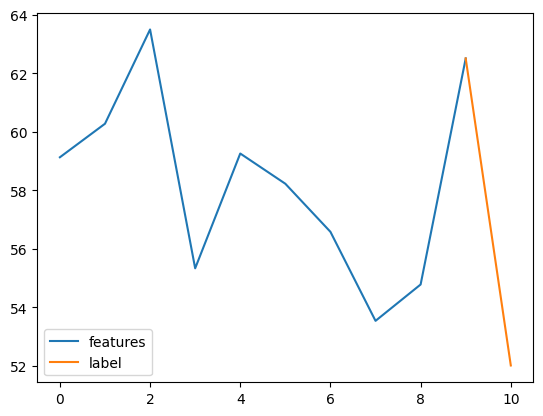

In [19]:
plt.plot(np.arange(10), batch_of_features[0].numpy(), label='features')
plt.plot(np.arange(9,11), [batch_of_features[0].numpy()[-1], batch_of_labels[0].numpy()], label='label');
plt.legend()

Now that you have tested your `windowed_dataset` function, use it to create your train dataset. For that, just run the cell below

In [20]:
# Apply the processing to the whole training series
train_dataset = windowed_dataset(series_train, WINDOW_SIZE)

In [21]:
# Test your code!
unittests.test_windowed_dataset(windowed_dataset)

 All tests passed!


## Defining the model architecture

### Exercise 2: create_model 

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you model architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Remember that this time you are predicting the values of a time series, so use an appropriate loss for this task. There are many you can choose for, but for grading purposes, please stick to 'mse'. 

Hint:
- You will only need `Dense` layers.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.



In [22]:
# GRADED FUNCTION: create_model
def create_model(window_size):
    """Create model for predictions
    Args:
        window_size (int): length of window to use for prediction

    Returns:
        tf.keras.Model: model
    """
    ### START CODE HERE ###

    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(window_size,)),
        tf.keras.layers.Dense(6,activation="relu"),
        tf.keras.layers.Dense(6,activation="relu"),
        tf.keras.layers.Dense(1),
    ]) 

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9))
    
    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [23]:
# Get the untrained model
model = create_model(WINDOW_SIZE)

# Check the parameter count against a reference solution
unittests.parameter_count(model)

Your model has 175 total parameters and the reference is 3,200. You are good to go!

Your model has 175 trainable parameters and the reference is 3,200. You are good to go!


In [24]:
example_batch = train_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 1)


2024-10-04 07:01:14.664895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/osboxes/anaconda3/envs/tf/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-04 07:01:14.802355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Expected output:**
```
predictions have shape: (NUM_BATCHES, 1)

Where NUM_BATCHES is the number of batches you have set to your dataset.
```

Before going any further, check that the input and output dimensions of your model are correct. Do this by running the cell below:

In [25]:
print(f'Model input shape: {model.input_shape}')
print(f'Model output shape: {model.output_shape}')

Model input shape: (None, 20)
Model output shape: (None, 1)


You can also print a summary of your model to see what the architecture looks like. 

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │           126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175 (700.00 B)

 Trainable params: 175 (700.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Test your code!
unittests.test_create_model(create_model, windowed_dataset)

 All tests passed!


2024-10-04 07:01:15.450167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [28]:
# Train it
history = model.fit(train_dataset, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 603.1378
Epoch 2/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 145.2026

2024-10-04 07:01:16.268196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85.3693 
Epoch 3/100
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.1131  

2024-10-04 07:01:16.480913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:16.684633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.4546
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.9111 
Epoch 5/100


2024-10-04 07:01:16.877198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.4991 
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.3117  
Epoch 7/100


2024-10-04 07:01:17.289214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:17.462506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32.6789  
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.7562  
Epoch 9/100


2024-10-04 07:01:17.613758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:17.761432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.2428  
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33.8051  
Epoch 11/100


2024-10-04 07:01:17.899013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:18.042632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.9244  
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.6524  
Epoch 13/100


2024-10-04 07:01:18.182313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:18.330128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.7277  
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.3859  
Epoch 15/100


2024-10-04 07:01:18.481088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:18.623718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.8619  
Epoch 16/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.9283 
Epoch 17/100


2024-10-04 07:01:18.764243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:18.903297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.2100 
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.9740 
Epoch 19/100


2024-10-04 07:01:19.039932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:19.170870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.9707
Epoch 20/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.3968  
Epoch 21/100


2024-10-04 07:01:19.309769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:19.452461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.7783  
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.3615 
Epoch 23/100


2024-10-04 07:01:19.598885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:19.737118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.8880  
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.4713 
Epoch 25/100


2024-10-04 07:01:19.876977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:20.020615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32.3226  
Epoch 26/100


2024-10-04 07:01:20.215009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.5915  
Epoch 27/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.0052 
Epoch 28/100


2024-10-04 07:01:20.510160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:20.662068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.0528  
Epoch 29/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.6809 
Epoch 30/100


2024-10-04 07:01:20.816339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:20.956809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.4597  
Epoch 31/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32.9164  
Epoch 32/100


2024-10-04 07:01:21.104708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:21.247513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.5957  
Epoch 33/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33.0776 
Epoch 34/100


2024-10-04 07:01:21.396453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:21.533180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.6502
Epoch 35/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.8575  
Epoch 36/100


2024-10-04 07:01:21.668558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:21.809070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.9981  
Epoch 37/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.5707  
Epoch 38/100


2024-10-04 07:01:21.957171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:22.105561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.3973 
Epoch 39/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.3417  
Epoch 40/100


2024-10-04 07:01:22.245680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:22.409142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.1416  
Epoch 41/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.0112 
Epoch 42/100


2024-10-04 07:01:22.550282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:22.685481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33.9776  
Epoch 43/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.3877 
Epoch 44/100


2024-10-04 07:01:22.825446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:22.966800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.0706  
Epoch 45/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.6173
Epoch 46/100


2024-10-04 07:01:23.110865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:23.271439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.3281 
Epoch 47/100


2024-10-04 07:01:23.470919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.1376  
Epoch 48/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.7424 
Epoch 49/100


2024-10-04 07:01:23.756029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:23.894283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.8040 
Epoch 50/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.1948
Epoch 51/100


2024-10-04 07:01:24.023580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:24.160727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.1614 
Epoch 52/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.7306 
Epoch 53/100


2024-10-04 07:01:24.287808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:24.423004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.6296  
Epoch 54/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 25.7206
Epoch 55/100


2024-10-04 07:01:24.572936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:24.698936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.3967  
Epoch 56/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.4446 
Epoch 57/100


2024-10-04 07:01:24.847232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:24.989315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.3614  
Epoch 58/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.7352 
Epoch 59/100


2024-10-04 07:01:25.128322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:25.262885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.2867  
Epoch 60/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.4751  
Epoch 61/100


2024-10-04 07:01:25.447303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:25.586688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.7043  
Epoch 62/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.2160 
Epoch 63/100


2024-10-04 07:01:25.736874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:25.916141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.4344 
Epoch 64/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.3055 
Epoch 65/100


2024-10-04 07:01:26.050838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:26.186323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.1435  
Epoch 66/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.7339 
Epoch 67/100


2024-10-04 07:01:26.335509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:26.479083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.0725 
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.9819 
Epoch 69/100


2024-10-04 07:01:26.621031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:26.759987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.9760  
Epoch 70/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.3712  
Epoch 71/100


2024-10-04 07:01:26.899732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:27.041123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.5662   
Epoch 72/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.7465


2024-10-04 07:01:27.187632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:27.386964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 73/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.7665  
Epoch 74/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.0044
Epoch 75/100


2024-10-04 07:01:27.595963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:27.750914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.9934
Epoch 76/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.3706  
Epoch 77/100


2024-10-04 07:01:28.027204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:28.190913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.2610
Epoch 78/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.3130  
Epoch 79/100


2024-10-04 07:01:28.482254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:28.636225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.5895  
Epoch 80/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.8238  
Epoch 81/100


2024-10-04 07:01:28.787886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:28.936701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.0183
Epoch 82/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 10.4957

2024-10-04 07:01:29.109143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1785  
Epoch 83/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 198.6635

2024-10-04 07:01:29.353909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.3302
Epoch 84/100


2024-10-04 07:01:29.657426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.7176
Epoch 85/100


2024-10-04 07:01:29.987211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.6585
Epoch 86/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.0736  
Epoch 87/100


2024-10-04 07:01:30.331926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:30.512400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.9420  
Epoch 88/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.8964
Epoch 89/100


2024-10-04 07:01:30.661810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:30.848097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.9156 
Epoch 90/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 8.4099

2024-10-04 07:01:31.130975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.6810
Epoch 91/100


2024-10-04 07:01:31.416249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.5429
Epoch 92/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.9274
Epoch 93/100


2024-10-04 07:01:31.723565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:31.907886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.5886
Epoch 94/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.6524 

2024-10-04 07:01:32.193927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.6451
Epoch 95/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 9.9602

2024-10-04 07:01:32.421230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.0729
Epoch 96/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.2545  
Epoch 97/100


2024-10-04 07:01:32.706381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:32.859748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.8365  
Epoch 98/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33.7713  
Epoch 99/100


2024-10-04 07:01:33.014609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:33.151259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.1831
Epoch 100/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.2985  


2024-10-04 07:01:33.335628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 07:01:33.524162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Now go ahead and plot the training loss so you can monitor the learning process.

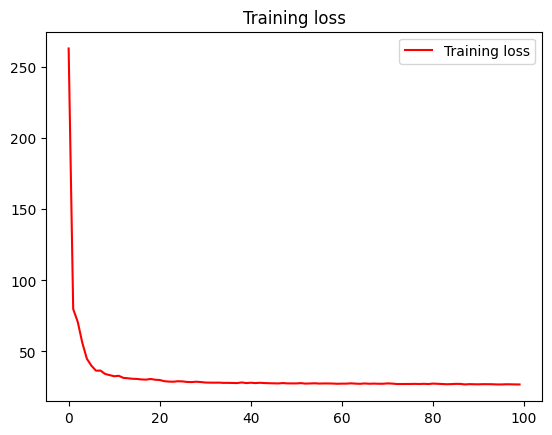

In [29]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [30]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

You will also be generating `predict_forecast` function, that simply computes predictions for all values in the validation data. 

In [31]:
def generate_forecast(model, series, window_size):
    forecast = []
    for time in range(SPLIT_TIME, len(series)):
        pred = model.predict(series[time-window_size:time][np.newaxis], verbose=0)
        forecast.append(pred[0][0])
    return forecast

Now, go ahead and make the predictions. This run should take no more time than the actual training.  

In [32]:
# Save the forecast
dnn_forecast = generate_forecast(model, SERIES, WINDOW_SIZE)

You can now plot the true series, and the predicted series in order to get a visual estimate of how good your model is doing.

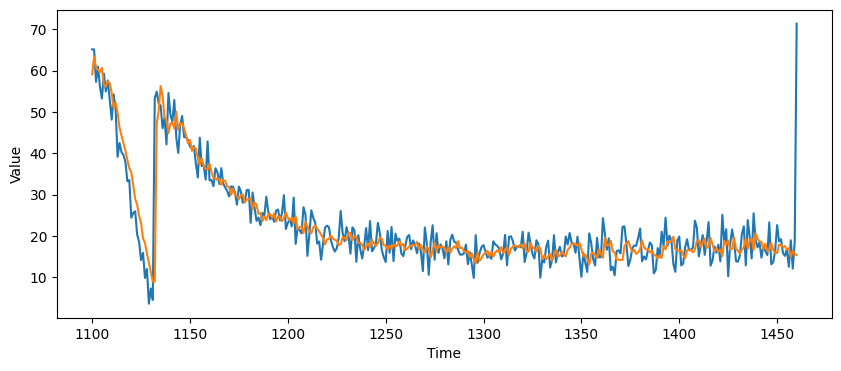

In [33]:
# Plot it
plt.figure(figsize=(10, 4))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/forecast.png" width="800">
</div>

Finally, go ahead and compute the MSE and MAE metrics using the `compute_metrics` function you defined earlier.

In [34]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 28.03, mae: 3.23 for forecast


**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the MSE in a binary file which will be used for grading and after doing so, submit your assigment for grading.

In [35]:
# ONLY RUN THIS CELL IF YOUR MSE ACHIEVED THE DESIRED MSE LEVEL
# Save your model 
model.save('trained_model.keras')

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series while also learning how to leverage Tensorflow's Dataset class to process time series data!

**Keep it up!**